# **Digital Signal and Image Management - Assignement 4**<br/>

**Master's Degree in Data Science (A.Y. 2024/2025)**<br/>
**University of Milano - Bicocca**<br/>

Student: Sara **Nava**, mat. **870885**

## **Assignement Description**

**Approach:**

Implement a script for stitching two images, following the guidelines shown during the laboratory.

Rules:
1. Use a pair of custom images (different from the ones provided). The two images must have a partial overlap.
2. Extract keypoints and find matches (no sorting/filtering matches is needed here).
3. Find the homography which describes the transformation from the second set of points to the first one.
4. Apply the homography to the second image.
5. Integrate the first image.

**Rules:**

1. It is not allowed to use `cv.createStitcher()` or other complete functions for image stitching.
2. You should, however, use pre-made functions for the computation of the homography and for image warping.

## **Import packages**
Import main packages

In [1]:
# Import
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv # OpenCV
import os

## **Load Data**

To import images from Google Drive, run the following code:

In [2]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Define the directory path from which get images:

In [3]:
my_path = 'gdrive/My Drive/DSIM 24-25 - Assignements Nava Sara/Ass4 - Images GEarth'

To generate two images suitable for stitching, photos of the same 360-degree landscape were captured from [Google Earth](https://earth.google.com/earth/d/1yG89OdycEtT-wu9CUD_-PRUNQHnq4xBM?usp=drive_link) (link to the selected landscape, *Spiaggia del Viticcio, Isola d'Elba,* photo by *Visit Elba 360*).

The process involved shifting the view to different angles while ensuring that reference elements within the landscape remained visible to serve as overlapping areas for the stitching process.

The images were obtained by taking screenshots of the Google Earth page—first from one angle of the landscape and then from another—cropping only the relevant portion of the screen (in this case, the landscape section of the web page).

Subsequently, the following code is implemented to standardize the dimensions of the two images by determining the minimum width and height between the two photos and applying these dimensions to the larger image.

Images are available at this [link](https://drive.google.com/drive/folders/1vyD9IijONC3L0nR-UtONqaZzvGnAvwa2?usp=sharing) (free access to all members of University of Milano - Bicocca).

In [4]:
# Load images
img1 = cv.imread(f'{my_path}/elba1_screen.png')
img2 = cv.imread(f'{my_path}/elba2_screen.png')

# Obtain images shape
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

# Compute the minimum width and height
new_height = min(height1, height2)
new_width = min(width1, width2)

# Cut images by setting new_height and new_width as new dimensions
img1_resized = img1[:new_height, :new_width]
img2_resized = img2[:new_height, :new_width]

# Save them
cv.imwrite(f'{my_path}/ass4_1.jpg', img1_resized)
cv.imwrite(f'{my_path}/ass4_2.jpg', img2_resized)

True

Now, import new images:

In [5]:
# Import resized images
im1 = cv.imread(f'{my_path}/ass4_1.jpg', cv.IMREAD_GRAYSCALE)
im2 = cv.imread(f'{my_path}/ass4_2.jpg', cv.IMREAD_GRAYSCALE)

Ensure that the two images have consistent dimensions:

In [6]:
# Print images shape
im1.shape, im2.shape

((877, 2183), (877, 2183))

The two images of the selected landscape share the exact same dimensions, each measuring 877 pixels in height and 2183 pixels in width.

Now print them:

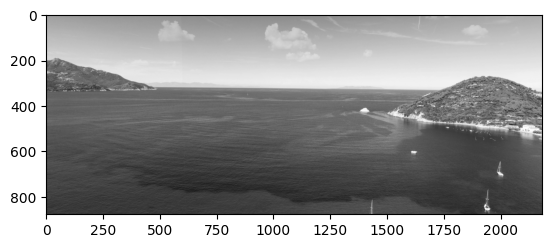

In [7]:
# Print the first image
plt.imshow(im1, cmap='gray')

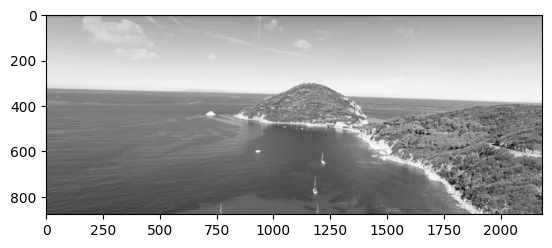

In [8]:
# Print the second image
plt.imshow(im2, cmap='gray')

As can be observed, the area that will serve as the key reference point for stitching is the small section of land protruding from the water. The final result of the stitching process will be a panoramic view of the cove, clearly showcasing both its ends as well as the entire maritime landscape.

## **Extract Keypoints and Find Matches**

To proceed with stitching the two images, it is essential to extract **key points** and **corresponding features** in both images to establish points of alignment.

[**Keypoints**](https://encord.com/glossary/keypoints-definition/) refer to distinctive or **salient points in an image or video** that can be used to identify, describe, or match objects or features in the scene. Keypoints are typically chosen based on their stability, distinctiveness, and repeatability, and are often used as a basis for tasks such as object detection, tracking, recognition, and matching.

Keypoints may be represented by their coordinates in the image or by a feature descriptor that captures the immediate surroundings' texture or appearance.

The following code implements the keypoint extraction process, while the next paragraph provides a theoretical explanation of the procedure followed:



In [9]:
# Keypoints extraction
sift = cv.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)

# Features matching
bf = cv.BFMatcher.create(crossCheck=True)
matches = bf.match(features1, features2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

The [**SIFT**](https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html) (Scale-Invariant Feature Transform) algorithm is used to detect distinctive keypoints in the images `im1` and `im2`.

- **Keypoints** represent unique features of the image, such as corners, edges, or regions of high contrast.  
- For each keypoint, SIFT computes a **descriptor**, which is a vector representation characterizing the local region around the keypoint. These descriptors are stored in `features1` and `features2`.

Once the descriptors are extracted, the [**Brute Force Matcher (BFMatcher)**](https://docs.opencv.org/3.4/d3/da1/classcv_1_1BFMatcher.html#ac6418c6f87e0e12a88979ea57980c020) is employed to compare the descriptors from `im1` with those from `im2`.  
- The `crossCheck=True` option ensures bidirectional matching: a keypoint from `im1` must correspond to the best match in `im2` and vice versa.  
- The resulting matches, stored in `matches`, represent the set of correspondences between the keypoints of the two images.  

In [10]:
# Print the number of matching keypoints
len(matches)

1694

The number of extracted **keypoints** is equal to **1694**, indicating a sufficient level of detail in the image for feature matching. This number suggests that the image contains numerous unique features, which can be used effectively for stitching.

This code visualizes the **feature matches between two images**. The matches are **sorted by their quality** (i.e., lower distance indicates better matches), and a slider allows the user to adjust the number of displayed matches.

For instance, if `n_matches` is set to 10, the visualization will display the 10 best matches based on their importance. The matches are drawn using the [drawMatches](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html#ga7421b3941617d7267e3f2311582f49e1) function, which connects the matched keypoints from the two images with colored lines.

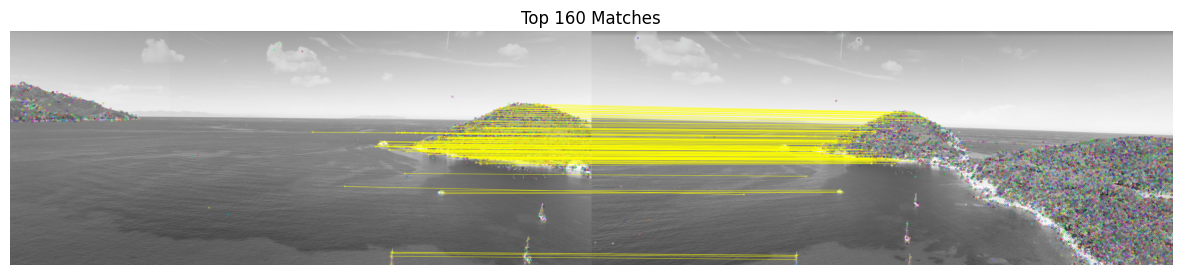

In [11]:
# Visualization of main matches

# @title  {"run":"auto"}
# Blur image
n_matches = 160 #@param {type:"slider", min:0, max:3000, step:20}
main_matches = sorted(matches, key=lambda x:x.distance)[0:n_matches]

# View matches
result = cv.drawMatches(im1, kps1, im2, kps2, main_matches, None, matchColor=[255, 255, 0])
plt.figure(figsize=(15, 7))
plt.imshow(result)
plt.title(f"Top {n_matches} Matches")
plt.axis("off")
plt.show()

When the **slider is set to zero**, the keypoints identified in the two images are clearly visible, represented as colored points. In the left image, most of the keypoints are concentrated on the portion of land protruding from the water, which will be used as the overlapping area for stitching. In the right image, however, many keypoints are also observed on the arm of land in the cove. However, it can be hypothesized that these points, as they do not belong to the overlapping area, are not among those relevant for performing the stitching of the image.

**Moving the slider**, for example, **to 160**, the most significant matches become visible. As expected, these matches are concentrated on the portion of land considered for the stitching. The most relevant points are located on the left side of the protruding land, which is the element common to both images.

**Increasing the number of matches to around 800**, it can be observed that the entire islet is correctly matched between the two images. Additionally, matches can be identified for other common elements, such as the boats visible in the sea.

When the **slider is set to the maximum number of matches**, some errors begin to appear. Specifically, matches are found between opposite points of the cove, which clearly do not correspond to overlapping areas in the two images.

In light of these observations, it can be concluded that the majority of the matches identified, particularly the most relevant ones, are accurate.

## **Find the homography which describes the transformation from the second set of points to the first one**

The key concept in this part is the **homography**.

[Homography](https://www.geeksforgeeks.org/what-is-homography-how-to-estimate-homography-between-two-images/) is a fundamental concept in computer vision that describes the **relationship between two different perspectives of a planar surface**. It allows to map points from one image to another, as long as the images capture the same scene from different viewpoints.

To **find the homography** which describes the **transformation from the second set of points to the first one**, the function `findHomography` is used ([ref](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780)), which takes four parameters as input:

- `src_pts`: A set of points in the source image.
- `dst_pts`: A set of corresponding points in the destination image.
- `cv.RANSAC`: An algorithm used to compute the homography robustly against outliers.
- `4.0`: The reprojection error threshold used to determine whether a point is an "outlier" or an "inlier" during the RANSAC process.

In this context, `src_pts` and `dst_pts` correspond to two arrays containing the coordinates of the matching points identified in the previous steps between the two images (for instance, the first coordinates of `src_pts` correspond to the matching point coordinates in `dst_pts`).

Since the homography needs to be applied to map the second image onto the first, the source image is `im2`, and the destination image is `im1`. Therefore, to obtain `src_pts`, the keypoints from the second image (`kps2`) are used, while for `dst_pts`, the keypoints from the first image (`kps1`) are used.

To retrieve the source and destination points, the matches obtained earlier are used. Each element in the `matches` array is a pair of integers `(trainIdx, queryIdx)`, representing the indices of the matching points detected in the source and destination images, respectively.

Here's the implemented code:

In [12]:
def myHomography(kps1, kps2, matches):
  # Points from the second image (im2)
  src_pts = np.float32([kps2[mat.trainIdx].pt for mat in matches]).reshape(-1, 1, 2)

  # Points from the first image (im1)
  dst_pts = np.float32([kps1[mat.queryIdx].pt for mat in matches]).reshape(-1, 1, 2)

  # Compute homography from im2 to im1
  H, status = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 4.0)
  return H

In [13]:
H = myHomography(kps1, kps2, matches)

In [14]:
H

array([[ 3.15045946e-01, -1.64583896e-02,  8.64323530e+02],
       [-1.14383934e-01,  7.67941493e-01,  7.40122614e+01],
       [-3.15222873e-04,  5.46251885e-06,  1.00000000e+00]])

The first two rows represent the **linear transformation** (scaling, rotation, and shear), while the third row accounts for the **perspective distortion**, ensuring the transformation works in a projective space.

The values in the top left (0.3150) and bottom right (1) indicate a slight scaling effect, while the presence of off-diagonal terms (such as -0.0164) suggests a minor rotation and shear in the mapping.

The values in the last column (864.32 and 74.01) represent the translation applied to the image.

## **Apply the Homography to the Second Image**

The application of the homography to the second image works as follows:

* A linear transformation is applied with the rules of matrix multiplication:<br/>
$
\begin{bmatrix}
x_{out}' \\
y_{out}' \\
z_{out}'
\end{bmatrix}
 = \begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{bmatrix}
\begin{bmatrix}
x_{in} \\
y_{in} \\
1
\end{bmatrix}$


* The output coordinates are 3-dimensional. Since 2-dimensional coordinates (pixel rows and columns) are needed, normalize by the third component:<br>
$x_{out} = \dfrac{x'_{out}}{z'_{out}}$<br/>
$y_{out} = \dfrac{y'_{out}}{z'_{out}}$


* In other terms, the output coordinates are computed as:<br/>
$x_{out} = \dfrac{h_{11}\cdot x_{in} + h_{12}\cdot y_{in} + h_{13}}{h_{31}\cdot x_{in} + h_{32}\cdot y_{in} + h_{33}}$<br/>
$y_{out} = \dfrac{h_{21}\cdot x_{in} + h_{22}\cdot y_{in} + h_{23}}{h_{31}\cdot x_{in} + h_{32}\cdot y_{in} + h_{33}}$


In [15]:
def myWarp(im, H):
  # Output image dimensions
  height, width = im.shape[:2]
  canvas_width = width * 2  # Double the length dimension

  # Apply the homography on the original image (im2) to obtain the warped image
  warped_image = cv.warpPerspective(im, H, (canvas_width, height))
  return warped_image

In [16]:
# Warped image
temp = myWarp(im2, H)

This function applies the homography matrix \( H \) to the second image (`im`) to create a transformed (warped) version of it. The output dimensions of the warped image are set by doubling the width of the original image (`canvas_width = width * 2`), which accommodates any horizontal shifts introduced by the transformation, ensuring the entire image remains visible.

To perform the transformation, the `cv.warpPerspective` [function](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) is used, which applies the homography matrix \( H \) to the image. This matrix defines how each pixel in the original image (`im`) should be mapped to a new position in the output image, based on the geometric transformation defined by the homography.

The warped image is then returned, displaying the transformed content of the second image, ready to be stitched/combined with the first image in the panorama.

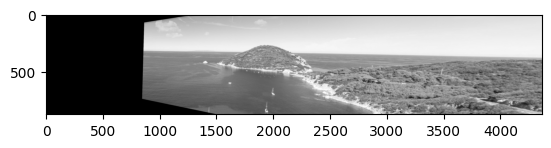

In [17]:
# Print result
plt.imshow(temp, cmap='gray')

As observed, the second image, correctly placed on the right, is stretched and rotated inward, starting to create the perspective depth effect typical of panoramic images, with the focal point of the stitching positioned at the center of what will be the final panoramic image.

## **Integrate the First Image**

At this point, it is necessary to integrate the first image in order to create the panoramic image.

To achieve this, the `myCollage` function is created, which will combine the warped second image with the first image, aligning them based on their corresponding features.

In [18]:
def myCollage(im_base, im_new):
  # Get original image dimension
  height, width = im1.shape[:2]

  # Add the target image to the warped
  collaged_image = im_base.copy()
  collaged_image[0:height, 0:width] = im_new
  return collaged_image

The process begins by obtaining the dimensions of the base image (`im_base`), that is the second warped image, which will serve as the foundation for the collage. These dimensions (height and width) are necessary to know where to position the first image (`im_new`) within the new canvas.

The function works by first creating a copy of the base image, ensuring that the original image remains unaltered. The next step involves placing the first image onto this canvas, starting from the top-left corner, covering the area defined by the dimensions of the base image. The `im_new` image is essentially overlaid on top of the base image, in this case, to form a collage.

The result is a new image with both the base and warped images combined, facilitating further processing to create a final, cohesive panoramic image.

Finally, apply the function and show results.

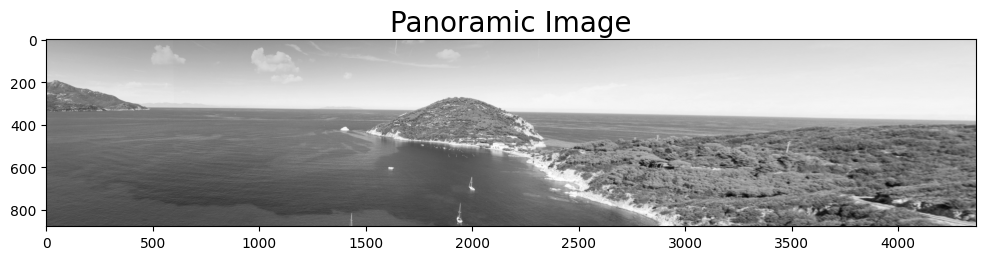

In [19]:
# Apply the function to obtain the final panoramic image
result = myCollage(temp, im1)

# Visualize result
plt.figure(figsize=(12, 8))
plt.imshow(result, cmap='gray')
plt.title('Panoramic Image', fontsize=20)
plt.show()

Text(0.5, 1.0, 'Origin Image')

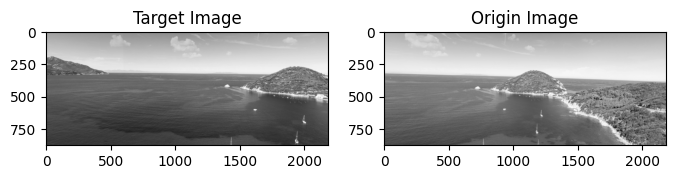

In [20]:
# Print original images
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.imshow(im1, cmap='gray')
plt.title('Target Image', fontsize=12)

plt.subplot(1,2,2)
plt.imshow(im2, cmap='gray')
plt.title('Origin Image', fontsize=12)

The resulting panorama is truly satisfying: the small island is centrally positioned in the image, and it does not appear distorted, even though it was more extended in the target image.

What’s particularly interesting is that even the smallest details, like the boats and clouds in the sky, have been accurately incorporated into the image, along with the various reflections in the water.

In [21]:
image1_path = f'{my_path}/ass4_1.jpg'
image2_path = f'{my_path}/ass4_2.jpg'

# Remove original images
os.remove(image1_path)
os.remove(image2_path)